***Introduction***

- This notebook imports the already downloaded GEOS NetCDF (nc) files during the desired hours and plots them based on their respective bands.
- You can overlay shapefiles onto the GOES data to investigate the spatial distribution of radiance for various features on the Earth's surface or within the atmosphere.
- Additionally, you can specify the preferred projection for plotting both the radiance data and the shapefile(s).


In [1]:
#import libraries
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from datetime import datetime, timedelta
import pytz
import metpy
import metpy.calc as mpcalc
import geopandas as gpd
import pyproj
from metpy.units import units
from cartopy.io.shapereader import Reader
from pyproj import Transformer
import math

In [2]:
#Three functions for importing, listing and sorting daylight files

def list_files_with_time_ranges(root_dir, filter_, time_ranges):
    """
    List NetCDF files matching the pattern and within the specified Pacific Time ranges.
    
    Parameters:
    root_dir (str): Root directory to search for files.
    filter_ (str): Filename pattern to search for.
    time_ranges (list of tuple): List of (start, end) tuples specifying the hour ranges in Pacific Time.
    
    Returns:
    list: List of file paths that match the pattern and time ranges.

    """
    files = []
    pacific_tz = pytz.timezone('America/Los_Angeles')
    
    for file_path in glob.glob(os.path.join(root_dir, '**', filter_), recursive=True):
        utc_dt = extract_datetime_from_filename(file_path)
        pacific_dt = utc_dt.astimezone(pacific_tz)
        hour = pacific_dt.hour
        
        if any(start <= hour <= end for start, end in time_ranges):
            files.append(file_path)
    
    return files

def extract_datetime_from_filename(filename):
    """
    Extract the start datetime from the filename.
    
    Parameters:
    filename (str): The filename from which to extract the datetime.
    
    Returns:
    datetime: Extracted datetime in UTC.

    """
    base_name = os.path.basename(filename)
    parts = base_name.split('_')
    date_str = parts[3][1:]
    year = int(date_str[:4])
    day_of_year = int(date_str[4:7])
    hour = int(date_str[7:9])
    minute = int(date_str[9:11])
    second = int(date_str[11:13])
    tenth_of_second = int(date_str[13:14])
    utc_dt = datetime(year, 1, 1, hour, minute, second, tenth_of_second * 100000).replace(tzinfo=pytz.utc) + timedelta(days=day_of_year - 1)
    return utc_dt

def get_band_number(filename):
    """
    Extract the band number from the filename.
    """
    return int(os.path.basename(filename).split('_')[1].split('M6C')[1])

In [3]:
def plot_shapefiles_and_radiance(gpds, proj_type, rad_files, x, y, geos):
    """
    Plot shapefiles and radiance arrays in subplots.
    
    Parameters:
    gpds (list): List of GeoDataFrames to plot.
    proj_type (cartopy.crs.CRS): Projection type for the plots.
    rad_files (list): List of NetCDF file paths containing radiance arrays.
    x (array): x-coordinate grid.
    y (array): y-coordinate grid.
    geos (cartopy.crs.CRS): Original projection of the radiance data.
    
    Returns:
    None
    """
    num_subplots = len(rad_files)
    if num_subplots == 0:
        print("No radiance arrays provided.")
        return

    # Calculate the number of rows and columns for subplots
    ncols = math.ceil(math.sqrt(num_subplots))
    nrows = math.ceil(num_subplots / ncols)

    # Repeat the list of GeoDataFrames to match the number of subplots
    gpds = (gpds * num_subplots)[:num_subplots]
    
    #projection here is for the whole map and it's an input
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows), subplot_kw={'projection': proj_type})

    # Flatten the array of Axes objects if needed
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()

    for idx, rad_file in enumerate(rad_files):
        # Load and parse the NetCDF data
        ds = xr.open_dataset(rad_file)
        rad = ds['Rad'].values
        band = ds['band_id'].item()


        # Trim the rad array to match the shape of the x and y arrays
        rad_trimmed = rad[:len(y) - 1, :len(x) - 1]

        # Create a meshgrid for x and y which is considered the pcolor mesh
        x_mesh, y_mesh = np.meshgrid(x, y)


        # Plot the NetCDF data with the given transform
        # geos here is the projection of the original file (here it's the goes data) 
        #and it's transformed to the projection of the map
        pcm = axs[idx].pcolormesh(x_mesh, y_mesh, rad_trimmed, transform=geos, cmap='viridis', shading='flat')
        
        for gdf in gpds:
            # Transform shapefile to the given CRS
            # here the gdf projection is transformed to the desired projection in the input to the function 
            gdf = gdf.to_crs(proj_type.proj4_init)
            projection = gdf.crs
            bounds = gdf.total_bounds  # returns (minx, miny, maxx, maxy)
            transformer_to_proj = Transformer.from_crs(projection, proj_type)
            minx, miny = transformer_to_proj.transform(bounds[0], bounds[1])
            maxx, maxy = transformer_to_proj.transform(bounds[2], bounds[3])
            extent_plus = 0.1  # Add a small buffer around the extent
            axs[idx].set_extent([minx-extent_plus, maxx+extent_plus, miny-extent_plus, maxy+extent_plus], crs=proj_type)

            # Plot the shapefile
            gdf.boundary.plot(ax=axs[idx], edgecolor='red', linewidth=1)

        # Add coastlines and states
        axs[idx].coastlines(resolution='50m', color='black', linewidth=1)
        axs[idx].add_feature(cfeature.STATES)
        
        # Add gridlines
        gl = axs[idx].gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

        # Add a colorbar
        cbar = plt.colorbar(pcm, ax=axs[idx], orientation='vertical', pad=0.05)
        cbar.set_label('Radiance')

        # Set title
        axs[idx].set_title(f'GOES-16 Radiance with Catchment - Band: {band}', loc='center', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()


In [4]:
#find and sort the files based on bands
root_dir = r'E:\goes_data\visualize'
filter_ = 'OR_ABI-L1b-RadC-M6C0*.nc'

# Load the shapefile
shapefile_path = r"E:\goes_data\catchements\Shapefile\mycatchment.shp"
watershed = gpd.read_file(shapefile_path)
dissolved = watershed.dissolve()
watershed=dissolved
# Define time ranges in hours - Pacific Time (e.g., [(1, 6), (9, 15)])
hour_ranges = [(1, 6), (7, 20)]
bands_to_plot = [1, 2, 3, 5] #select any avalible band

# List files matching the pattern and within the specified Pacific Time ranges
filtered_files = list_files_with_time_ranges(root_dir, filter_, hour_ranges)
sorted_filtered_files = sorted(filtered_files, key=lambda file: get_band_number(file))
sorted_filtered_files = [file for file in sorted_filtered_files if get_band_number(file) in bands_to_plot]

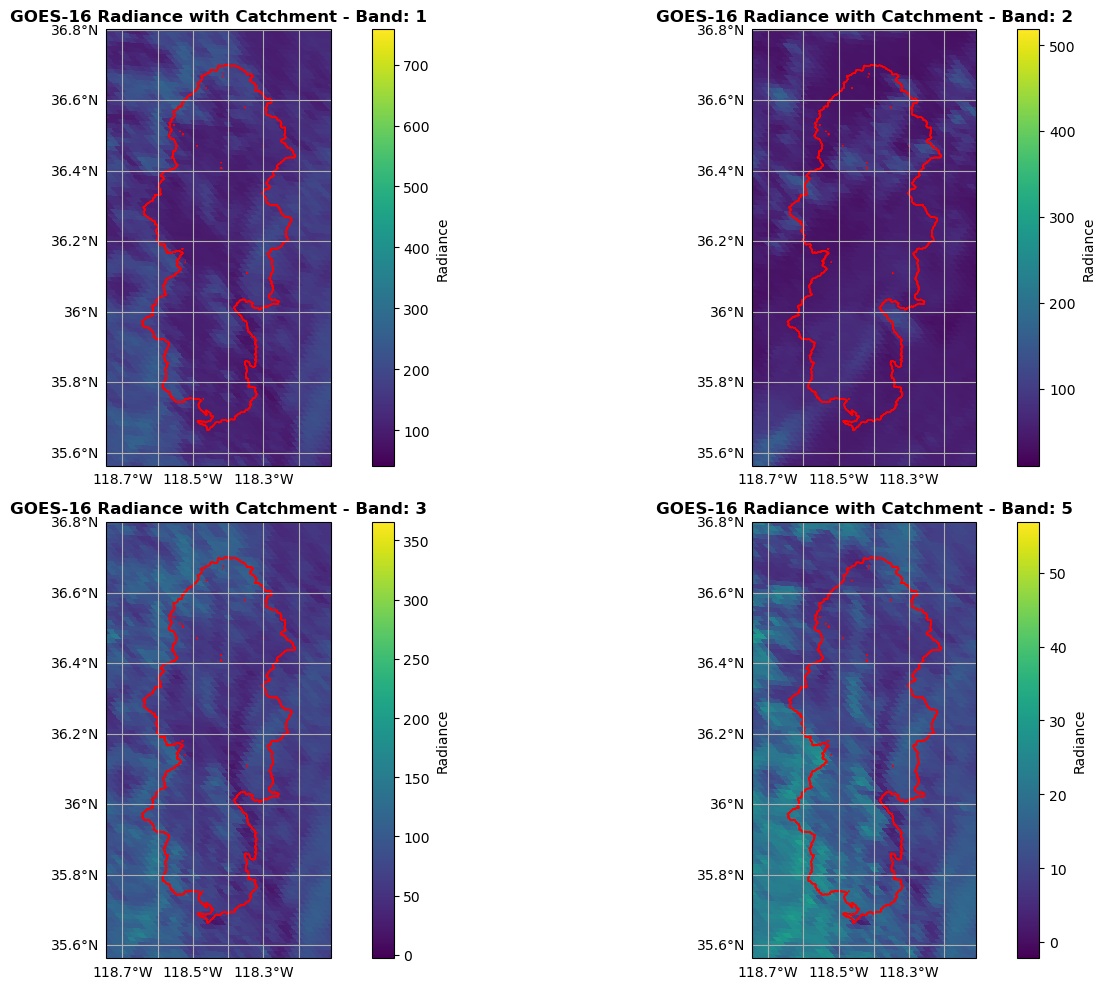

CPU times: total: 5min 56s
Wall time: 8min 12s


In [6]:
%%time
# Check if there are any filtered files to process and plot
if not sorted_filtered_files:
    print("No files found for the specified time ranges and bands.")
else:
    # Extract Rad, x, y, and geos from the first file to use as a reference
    ds = xr.open_dataset(sorted_filtered_files[0])
    dat = ds.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs
    x = dat.x.values
    y = dat.y.values
    proj_type = ccrs.PlateCarree()
    # Call the plotting function
    plot_shapefiles_and_radiance([watershed], proj_type, sorted_filtered_files, x, y, geos)